In [1]:
from tensorflow.keras import Sequential, Model
from keras.layers import *
import extensionbase as ex
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [2]:
inp = Input((28, 28, 1))
conv_28 = Conv2D(4, (3, 3), padding="same", activation="relu")(inp)  # 28,28,4
fl_conv_28 = Flatten()(conv_28)

conv_14_st = Conv2D(8, (3, 3), (2, 2), padding="same", activation="relu")(conv_28)  # 14,14,8
conv_14 = Conv2D(8, (3, 3), padding="same", activation="relu")(conv_14_st)
fl_conv_14 = Flatten()(conv_14)

conv_7_st = Conv2D(16, (3, 3), (2, 2), padding="same", activation="relu")(conv_14)  # 7,7,16
conv_7 = Conv2D(16, (3, 3), padding="same", activation="relu")(conv_7_st)
fl_conv_7 = Flatten()(conv_7)

conc = concatenate([
    fl_conv_28,
    fl_conv_14,
    fl_conv_7
])
drop1 = Dropout(0.35)(conc)
dense = Dense(64, "relu")(drop1)
drop2 = Dropout(0.25)(dense)
output = Dense(10, "softmax")(drop2)

model = Model(inp, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 4)    40          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 8)    296         ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 8)    584         ['conv2d_1[0][0]']               
                                                                                              

In [3]:
model.compile(optimizer="adam",  # Выбираю оптимизатор для модели
              loss='categorical_crossentropy',  # Выбираю ошибку
              metrics=['accuracy'])  # Метрика оценки работы сети

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

sd = 75  # sd - size drop - чем меньше этот параметр, тем лучше, но кушает много оперативки, оптимально 100. Рассчитывается так 60_000 * 77 // sd такими кусочками вам будут подаваться данные
gen = ex.gen_extension_base(x_train, y_train, size_drop=sd)

ah = []  #  Списки для оценки
av = []
ep = 2
for j in range(ep):  # Количество эпох
    for i in range(sd):
        x, y = next(gen)  # получаем кусочек данных
        his = model.fit(x, y, batch_size=77, validation_split=0.25, shuffle=True)
        # validation_split=0.25 значит что 25% данных уходит на то, чтобы посмотреть как обучилась нейронная сети полсе 1 эпохи в нашем случае на кусочке данных
        ah.append(his.history["accuracy"])  # добавляем статистические данных нашей НН
        # "accuracy" - это качество обучение нашей сети на тренировочной выборке
        av.append(his.history["val_accuracy"])
        # "val_accuracy" - это качество обучение нашей сети на валидационной выборке
        print(j, i)

2023-04-28 11:29:59.862983: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


600/600 [==============================] - 8s 12ms/step - loss: 0.5960 - accuracy: 0.8023 - val_loss: 0.2260 - val_accuracy: 0.9344
0 0
600/600 [==============================] - 7s 11ms/step - loss: 0.2469 - accuracy: 0.9196 - val_loss: 0.1936 - val_accuracy: 0.9460
0 1
600/600 [==============================] - 8s 13ms/step - loss: 0.1314 - accuracy: 0.9580 - val_loss: 0.1228 - val_accuracy: 0.9583
0 2
600/600 [==============================] - 7s 12ms/step - loss: 0.1328 - accuracy: 0.9582 - val_loss: 0.1032 - val_accuracy: 0.9728
0 3
600/600 [==============================] - 7s 12ms/step - loss: 0.1140 - accuracy: 0.9620 - val_loss: 0.1342 - val_accuracy: 0.9579
0 4
600/600 [==============================] - 7s 12ms/step - loss: 0.0998 - accuracy: 0.9690 - val_loss: 0.2147 - val_accuracy: 0.9475
0 5
600/600 [==============================] - 7s 12ms/step - loss: 0.0952 - accuracy: 0.9695 - val_loss: 0.0989 - val_accuracy: 0.9761
0 6
600/600 [==============================] - 7s 12

0.9837012887001038 % - Финальный результат сети на валидационной выборке


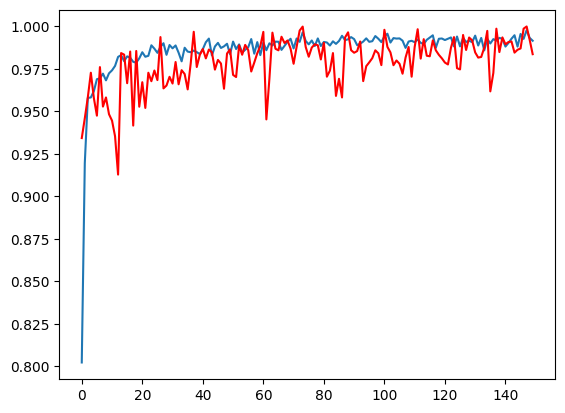

In [5]:
print(*av[-1], "% - Финальный результат сети на валидационной выборке")
plt.plot(ah)
plt.plot(av, c="r")
# Выводим графики на экран где синий - это "accuracy", a красный - это "val_accuracy"
plt.show()

In [6]:
model.save("Model MegaCNN 2epD", save_format="h5")
